In [1]:
import time
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import dgl
import networkx as nx
import torch
import torch.nn as nn

import utils
from gsp_utils.baselines_archs import GCNN_2L
from gsp_utils.baselines_models import NodeClassModel, GF_NodeClassModel
from gsp_utils.data import normalize_gso
from src.arch import GFGCN, GFGCNLayer, GFGCN_noh_Layer, GFGCN_Spows

SEED = 15
# PATH = 'results/diff_filters/'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

torch.manual_seed(SEED)

cuda:0


In [2]:
# Auxiliary functions
def summary_table(acc, index_name):
    mean_accs = acc.mean(axis=1)
    med_accs = np.median(acc, axis=1)
    std_accs = acc.std(axis=1)
    return DataFrame(np.vstack((mean_accs, med_accs, std_accs)).T, columns=['mean accs', 'med', 'std'], index=index_name)

In [3]:
# Auxiliary functions
def compute_S_pows(S, K, device):
    N = S.shape[0]
    S_pows = torch.Tensor(torch.empty(K-1, N, N)).to(device)
    S_pows[0,:,:] = torch.Tensor(S).to(device)
    for k in range(1,K-1):
        S_pows[k,:,:] = S_pows[0,:,:] @ S_pows[k-1,:,:]

    return S_pows

In [4]:
# Dataset must be from DGL
dataset_name = 'WisconsinDataset'

A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device,
                                                     verb=True)
N = A.shape[0]

Dataset: WisconsinDataset
Number of nodes: 251
Number of features: 1703
Shape of signals: torch.Size([251, 1703])
Number of classes: 5
Norm of A: 22.69361114501953
Max value of A: 1.0
Proportion of validation data: 0.32
Proportion of test data: 0.20
Node homophily: 0.13
Edge homophily: 0.20


In [5]:
# BEST PARAMETERS
## Reaining params
N_RUNS = 10
N_EPOCHS = 200  # 5000
EPOCHS_h = 5 # 5 # 5
EPOCHS_W = 25 # 5 # 25
LR = .005
WD = 5e-4  # .001
DROPOUT = .5

# BEST PARAMETERS
## Architecture params
N_LAYERS = 3
K = 2
HID_DIM = 32 # 100

## Model params
NORM = True

IN_DIM = feat.shape[1]
OUT_DIM = n_class

ACT = nn.ReLU()  # nn.ELU()  # nn.ELU()
LAST_ACT = nn.Softmax()
LOSS_FN = nn.CrossEntropyLoss()  # nn.CrossEntropyLoss()

## Plotting eval/test acc/loss

In [6]:
# Parameters
epochs = N_EPOCHS
epochs_h = EPOCHS_h
epochs_W = EPOCHS_W
lr = LR
wd = WD
drop = DROPOUT
L = N_LAYERS
K_aux = K
hid_dim = HID_DIM
norm = True
act = ACT
lact = LAST_ACT
loss_fn = LOSS_FN
bias = True
patience = 200

iters_aux = 1

err1 = np.zeros(iters_aux)
err2 = np.zeros(iters_aux)
for i in range(iters_aux):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)

    arch = GFGCN_Spows(IN_DIM, hid_dim, OUT_DIM, L, K_aux, act=act, last_act=lact,
                dropout=drop, norm=norm, bias=bias, dev=device)
    S = torch.Tensor(A).to(device)
    model = GF_NodeClassModel(arch, S, K_aux, masks, loss_fn, device=device)
    loss, acc = model.train(feat, labels, epochs, lr, wd, epochs_h=epochs_h, epochs_W=epochs_W,
                            patience=patience)

    idx_max_acc = np.argmax(acc["val"])
    print(f'Test acc at best val: {acc["test"][idx_max_acc]:.3f}  -  Best test acc: {np.max(acc["test"]):.3f}')
    acc_val = model.test(feat, model.S, labels, masks['val'])
    acc_test = model.test(feat, model.S, labels, masks['test'])
    print(f'Test acc (based on loss): {acc_test:.3f}')

    err1[i] = acc["test"][idx_max_acc]
    err2[i] = acc_test

/home/srey/Investigacion/robust_minmax_gnn/src/arch.py:312: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(X)


Test acc at best val: 0.824  -  Best test acc: 0.882
Test acc (based on loss): 0.863


Acc at best val acc: 0.824 +- 0.000
Acc at test: 0.863 +- 0.000


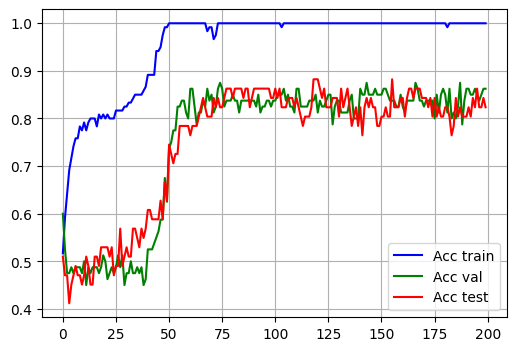

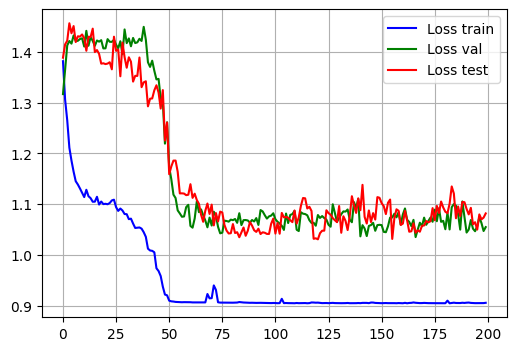

In [7]:
print(f'Acc at best val acc: {err1.mean():.3f} +- {err1.std():.3f}')
print(f'Acc at test: {err2.mean():.3f} +- {err1.std():.3f}')

# Plot
plt.figure(figsize=[6,4])
plt.plot(acc['train'], 'b-', label='Acc train')
plt.plot(acc['val'], 'g-', label='Acc val')
plt.plot(acc['test'], 'r-', label='Acc test')
plt.grid()
plt.legend()

plt.figure(figsize=[6,4])
plt.plot(loss['train'], 'b-', label='Loss train')
plt.plot(loss['val'], 'g-', label='Loss val')
plt.plot(loss['test'], 'r-', label='Loss test')
plt.grid()
plt.legend()

## Training paramerters

In [8]:
EXPS = [
        {'epochs': 200, 'lr': .001, 'wd': 1e-4, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 5e-4, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .001, 'wd': 5e-3, 'drop': .25},

        {'epochs': 200, 'lr': .005, 'wd': 1e-4, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .25},
        {'epochs': 200, 'lr': .005, 'wd': 5e-3, 'drop': .25},

        {'epochs': 200, 'lr': .005, 'wd': 1e-3, 'drop': .5},

        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': 0},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .5},
        {'epochs': 200, 'lr': .005, 'wd': 5e-4, 'drop': .75},

        {'epochs': 500, 'lr': .005, 'wd': 5e-4, 'drop': .25},
        {'epochs': 750, 'lr': .005, 'wd': 5e-4, 'drop': .25},
        {'epochs': 1000, 'lr': .001, 'wd': 5e-5, 'drop': .25},
        ]

best_accs1 = np.zeros((len(EXPS), N_RUNS))
best_val_accs1 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):        
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=exp['drop'], norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, exp['epochs'], exp['lr'], exp['wd'],
                             epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs1[j,i] = np.max(acc["test"])
        best_val_accs1[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}: {best_val_accs1[j,i]:.3f} ({best_accs1[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["lr"]}-{exp["wd"]}-{exp["drop"]}' for exp in EXPS]
table_over1 = summary_table(best_accs1, index_name)
table1 = summary_table(best_val_accs1, index_name)

-1: 200-0.001-0.0001-0.25: 0.431 (0.510)
-1: 200-0.001-0.0005-0.25: 0.510 (0.549)
-1: 200-0.001-0.001-0.25: 0.569 (0.588)
-1: 200-0.001-0.005-0.25: 0.529 (0.529)
-1: 200-0.005-0.0001-0.25: 0.725 (0.863)
-1: 200-0.005-0.0005-0.25: 0.843 (0.882)
-1: 200-0.005-0.001-0.25: 0.843 (0.882)
-1: 200-0.005-0.005-0.25: 0.824 (0.843)
-1: 200-0.005-0.001-0.5: 0.804 (0.882)
-1: 200-0.005-0.0005-0: 0.784 (0.843)
-1: 200-0.005-0.0005-0.5: 0.882 (0.882)
-1: 200-0.005-0.0005-0.75: 0.686 (0.745)
-1: 500-0.005-0.0005-0.25: 0.804 (0.882)


KeyboardInterrupt: 

In [ ]:
table1

,mean accs,med,std
200-0.005-0.0001-0.25,0.861765,0.862745,0.044486
200-0.005-0.0005-0.25,0.860784,0.852941,0.039654
200-0.01-0.001-0.25,0.844118,0.852941,0.052787
200-0.005-0.001-0.25,0.845098,0.843137,0.040612
200-0.005-0.001-0.5,0.852941,0.843137,0.029412
200-0.001-0.001-0.25,0.832353,0.843137,0.048219
200-0.05-0.005-0.25,0.756863,0.784314,0.103829
200-0.01-0.005-0.25,0.826471,0.833333,0.047738
200-0.005-0.005-0.25,0.835294,0.843137,0.056964
200-0.001-0.005-0.25,0.824510,0.823529,0.035875


## Model params

In [8]:
# h0, norm (norm, not norm, norm H), sep vs joint training, optimizers iters (W vs h)
EXPS = [
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        {'h0': 1, 'epochs': 1000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        {'h0': 1, 'epochs': 5000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},
        {'h0': 1, 'epochs': 10000, 'epochs_h': 1, 'epochs_W': 1, 'alt': False},        

        # {'h0': .1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 1, 'epochs_W': 1, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},   # Current best
        {'h0': 1, 'epochs': 200, 'epochs_h': 50, 'epochs_W': 50, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 100, 'epochs_W': 100, 'alt': True},
        {'h0': 1, 'epochs': 400, 'epochs_h': 25, 'epochs_W': 25, 'alt': True},

        {'h0': 1, 'epochs': 200, 'epochs_h': 10, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 25, 'epochs_W': 5, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 10, 'alt': True},
        {'h0': 1, 'epochs': 200, 'epochs_h': 5, 'epochs_W': 25, 'alt': True},
    ]


best_accs2 = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        if not exp['alt']:
            S_pows = compute_S_pows(A, K, device)
            model = NodeClassModel(arch, S_pows, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD)
        else:
            model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)
            _, acc = model.train(feat, labels, exp['epochs'], LR, WD, epochs_h=exp['epochs_h'],
                                 epochs_W=exp['epochs_W'])

        best_accs2[j,i] = np.max(acc["test"])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}: {best_val_accs2[j,i]:.3f} ({best_accs2[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["epochs"]}-{exp["epochs_h"]}-{exp["epochs_W"]}-{exp["alt"]}' for exp in EXPS]
table_over2 = summary_table(best_accs2, index_name)
table2 = summary_table(best_val_accs2, index_name)

-1: 1-1-False: 0.510 (0.549)
-1: 1-1-False: 0.431 (0.588)
-1: 1-1-False: 0.745 (0.804)
-1: 1-1-False: 0.490 (0.588)
-1: 1-1-True: 0.549 (0.569)
-1: 10-10-True: 0.824 (0.882)
-1: 25-25-True: 0.804 (0.902)
-1: 50-50-True: 0.863 (0.882)
-1: 100-100-True: 0.843 (0.882)
-1: 25-25-True: 0.882 (0.882)
-1: 10-5-True: 0.824 (0.863)
-1: 25-5-True: 0.765 (0.863)
-1: 5-10-True: 0.784 (0.863)
-1: 5-25-True: 0.824 (0.882)
-2: 1-1-False: 0.569 (0.686)
-2: 1-1-False: 0.627 (0.667)
-2: 1-1-False: 0.882 (0.882)
-2: 1-1-False: 0.667 (0.686)
-2: 1-1-True: 0.627 (0.647)
-2: 10-10-True: 0.863 (0.941)
-2: 25-25-True: 0.882 (0.922)
-2: 50-50-True: 0.882 (0.922)
-2: 100-100-True: 0.863 (0.922)
-2: 25-25-True: 0.902 (0.922)
-2: 10-5-True: 0.843 (0.922)
-2: 25-5-True: 0.863 (0.922)
-2: 5-10-True: 0.922 (0.922)
-2: 5-25-True: 0.863 (0.922)
-3: 1-1-False: 0.529 (0.549)
-3: 1-1-False: 0.471 (0.529)
-3: 1-1-False: 0.843 (0.922)
-3: 1-1-False: 0.902 (0.902)
-3: 1-1-True: 0.549 (0.569)
-3: 10-10-True: 0.863 (0.922)
-3

In [9]:
table2

,mean accs,med,std
200-1-1-False,0.505882,0.539216,0.070588
1000-1-1-False,0.545098,0.558824,0.113590
5000-1-1-False,0.670588,0.656863,0.170667
10000-1-1-False,0.576471,0.529412,0.121252
200-1-1-True,0.527451,0.539216,0.051468
200-10-10-True,0.847059,0.843137,0.050980
200-25-25-True,0.868627,0.882353,0.045607
200-50-50-True,0.835294,0.843137,0.037409
200-100-100-True,0.862745,0.852941,0.024802
400-25-25-True,0.856863,0.872549,0.037255


## Architecture design

In [10]:
# layers, filter order, weightd
EXPS = [
        # {'L': 2, 'K': 3, 'hid_dim': 8},
        # {'L': 2, 'K': 3, 'hid_dim': 16},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 3, 'hid_dim': 32},
        {'L': 2, 'K': 4, 'hid_dim': 32},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 4, 'K': 2, 'hid_dim': 32},
        {'L': 5, 'K': 2, 'hid_dim': 32},
        {'L': 6, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 3, 'hid_dim': 32},
        {'L': 4, 'K': 3, 'hid_dim': 32},

        {'L': 2, 'K': 2, 'hid_dim': 8},
        {'L': 2, 'K': 2, 'hid_dim': 32},
        {'L': 2, 'K': 2, 'hid_dim': 50},
        {'L': 2, 'K': 2, 'hid_dim': 75},
        {'L': 2, 'K': 2, 'hid_dim': 100},

        {'L': 2, 'K': 3, 'hid_dim': 50},
        {'L': 2, 'K': 3, 'hid_dim': 75},
        {'L': 2, 'K': 3, 'hid_dim': 100},

        {'L': 3, 'K': 2, 'hid_dim': 32},
        {'L': 3, 'K': 2, 'hid_dim': 50},
        {'L': 3, 'K': 3, 'hid_dim': 50},
        ]

best_accs3 = np.zeros((len(EXPS), N_RUNS))
best_val_accs3 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, exp['hid_dim'], OUT_DIM, exp['L'], exp['K'], act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  exp['K'], masks, LOSS_FN, device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs3[j,i] = np.max(acc["test"])
        best_val_accs3[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["L"]}-{exp["K"]}-{exp["hid_dim"]}: {best_val_accs3[j,i]:.3f} ({best_accs3[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["L"]}-{exp["K"]}-{exp["hid_dim"]}' for exp in EXPS]
table_over3 = summary_table(best_accs3, index_name)
table3 = summary_table(best_val_accs3, index_name)

/home/srey/Investigacion/robust_minmax_gnn/src/arch.py:312: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(X)


-1: 2-2-32: 0.765 (0.882)
-1: 2-3-32: 0.784 (0.843)
-1: 2-4-32: 0.784 (0.824)
-1: 3-2-32: 0.824 (0.863)
-1: 4-2-32: 0.843 (0.863)
-1: 5-2-32: 0.824 (0.863)
-1: 6-2-32: 0.588 (0.588)
-1: 3-3-32: 0.784 (0.863)
-1: 4-3-32: 0.608 (0.647)
-1: 2-2-8: 0.510 (0.569)
-1: 2-2-32: 0.745 (0.882)
-1: 2-2-50: 0.824 (0.882)
-1: 2-2-75: 0.863 (0.902)
-1: 2-2-100: 0.843 (0.863)
-1: 2-3-50: 0.824 (0.882)
-1: 2-3-75: 0.784 (0.804)
-1: 2-3-100: 0.804 (0.863)
-1: 3-2-32: 0.882 (0.882)
-1: 3-2-50: 0.745 (0.882)
-1: 3-3-50: 0.824 (0.863)
-2: 2-2-32: 0.902 (0.922)
-2: 2-3-32: 0.882 (0.922)
-2: 2-4-32: 0.882 (0.902)
-2: 3-2-32: 0.863 (0.941)
-2: 4-2-32: 0.902 (0.922)
-2: 5-2-32: 0.882 (0.922)
-2: 6-2-32: 0.863 (0.902)
-2: 3-3-32: 0.902 (0.922)
-2: 4-3-32: 0.765 (0.824)
-2: 2-2-8: 0.706 (0.784)
-2: 2-2-32: 0.843 (0.922)
-2: 2-2-50: 0.882 (0.922)
-2: 2-2-75: 0.863 (0.902)
-2: 2-2-100: 0.824 (0.922)
-2: 2-3-50: 0.843 (0.961)
-2: 2-3-75: 0.882 (0.922)
-2: 2-3-100: 0.882 (0.922)
-2: 3-2-32: 0.902 (0.941)
-2: 3-2-50

In [11]:
table3

,mean accs,med,std
2-2-32,0.860784,0.872549,0.049952
2-3-32,0.852941,0.862745,0.030691
2-4-32,0.800000,0.813725,0.055321
3-2-32,0.849020,0.843137,0.035130
4-2-32,0.849020,0.843137,0.027799
5-2-32,0.790196,0.823529,0.088148
6-2-32,0.725490,0.754902,0.098820
3-3-32,0.823529,0.843137,0.058824
4-3-32,0.609804,0.568627,0.172159
2-2-8,0.635294,0.607843,0.101961


## GSO, bias, and batch norm

In [10]:
EXPS = [{'GSO': 'orig', 'bias': True, 'bn': False},
        {'GSO': 'trans', 'bias': True, 'bn': False},
        {'GSO': 'sym', 'bias': True, 'bn': False},

        {'GSO': 'orig', 'bias': True, 'bn': True},
        {'GSO': 'trans', 'bias': True, 'bn': True},
        {'GSO': 'sym', 'bias': True, 'bn': True},

        {'GSO': 'orig', 'bias': False, 'bn': False},
        {'GSO': 'sym', 'bias': False, 'bn': False},
        ]

best_accs3b = np.zeros((len(EXPS), N_RUNS))
best_val_accs3b = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        if exp['GSO'] == 'sym':
            A_aux = (A + A.T)/2
            A_aux = np.where(A_aux > 0, 1, 0)
        elif exp['GSO'] == 'trans':
            A_aux = A.T
        else:
            A_aux = A
        S = torch.Tensor(A_aux).to(device)

        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=NORM, dev=device)
        model = GF_NodeClassModel(arch, S,  K, masks, LOSS_FN, device=device)        
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                              epochs_W=EPOCHS_W)


        best_accs3b[j,i] = np.max(acc["test"])
        best_val_accs3b[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'- {i+1}: {exp["GSO"]}-{exp["bias"]}-{exp["bn"]}: {best_val_accs3b[j,i]:.3f} ({best_accs3b[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["GSO"]}-{exp["bias"]}-{exp["bn"]}' for exp in EXPS]
table_over3b = summary_table(best_accs3b, index_name)
table3b = summary_table(best_val_accs3b, index_name)

- 1: orig-True-False: 0.843 (0.882)
- 1: trans-True-False: 0.843 (0.863)
- 1: sym-True-False: 0.824 (0.843)
- 1: orig-True-True: 0.843 (0.882)
- 1: trans-True-True: 0.804 (0.863)
- 1: sym-True-True: 0.843 (0.843)
- 1: orig-False-False: 0.843 (0.882)
- 1: sym-False-False: 0.824 (0.863)
- 2: orig-True-False: 0.902 (0.922)
- 2: trans-True-False: 0.804 (0.882)
- 2: sym-True-False: 0.882 (0.922)
- 2: orig-True-True: 0.882 (0.922)
- 2: trans-True-True: 0.765 (0.882)
- 2: sym-True-True: 0.804 (0.902)
- 2: orig-False-False: 0.863 (0.922)
- 2: sym-False-False: 0.863 (0.902)
- 3: orig-True-False: 0.843 (0.902)
- 3: trans-True-False: 0.902 (0.961)
- 3: sym-True-False: 0.882 (0.961)
- 3: orig-True-True: 0.902 (0.941)
- 3: trans-True-True: 0.882 (0.882)
- 3: sym-True-True: 0.843 (0.922)
- 3: orig-False-False: 0.882 (0.922)
- 3: sym-False-False: 0.902 (0.922)
- 4: orig-True-False: 0.922 (0.941)
- 4: trans-True-False: 0.882 (0.902)
- 4: sym-True-False: 0.902 (0.922)
- 4: orig-True-True: 0.863 (0.902)

In [14]:
table3b

,mean accs,med,std
orig-True-False,0.876471,0.882353,0.030440
trans-True-False,0.854902,0.843137,0.033044
sym-True-False,0.850980,0.852941,0.044019
orig-True-True,0.856863,0.852941,0.031677
trans-True-True,0.847059,0.852941,0.035942
sym-True-True,0.831373,0.833333,0.035294
orig-False-False,0.854902,0.862745,0.031859
sym-False-False,0.849020,0.843137,0.036208


## Nonlinearities and loss function

In [16]:
# layers, filter order, weightd
EXPS = [{'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.LogSoftmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ReLU(), 'lact': nn.Identity(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.ELU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.LeakyReLU(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},

        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.CrossEntropyLoss()},
        {'act': nn.Identity(), 'lact': nn.Softmax(dim=1), 'loss': nn.NLLLoss()},
        {'act': nn.Identity(), 'lact': nn.Identity(dim=1), 'loss': nn.CrossEntropyLoss()},]

best_accs4 = np.zeros((len(EXPS), N_RUNS))
best_val_accs4 = np.zeros((len(EXPS), N_RUNS))
t_i = time.time()
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    for j, exp in enumerate(EXPS):
        arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=exp['act'], last_act=exp['lact'],
                           dropout=DROPOUT, norm=NORM, dev=device)
        S = torch.Tensor(A).to(device)

        model = GF_NodeClassModel(arch, S,  K, masks, exp['loss'], device=device)
        _, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h, epochs_W=EPOCHS_W)

        best_accs4[j,i] = np.max(acc["test"])
        best_val_accs4[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'-{i+1}: {exp["act"]}-{exp["lact"]}-{exp["loss"]}: {best_val_accs4[j,i]:.3f} ({best_accs4[j,i]:.3f})')

ellapsed_t = (time.time()-t_i)/60
print(f'----- {ellapsed_t:.2f} mins -----')

# Get table with results
index_name = [f'{exp["act"]}-{exp["lact"]}-{exp["loss"]}' for exp in EXPS]
table_over4 = summary_table(best_accs4, index_name)
table4 = summary_table(best_val_accs4, index_name)

-1: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.804 (0.863)
-1: ReLU()-Softmax(dim=1)-NLLLoss(): 0.784 (0.863)
-1: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.824 (0.882)
-1: ReLU()-LogSoftmax(dim=1)-NLLLoss(): 0.824 (0.882)
-1: ReLU()-Identity()-CrossEntropyLoss(): 0.784 (0.863)
-1: ReLU()-Identity()-NLLLoss(): 0.529 (0.529)
-1: ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(): 0.765 (0.863)
-1: ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(): 0.784 (0.863)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(): 0.765 (0.863)
-1: LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(): 0.804 (0.882)
-1: Identity()-Softmax(dim=1)-CrossEntropyLoss(): 0.824 (0.843)
-1: Identity()-Softmax(dim=1)-NLLLoss(): 0.784 (0.843)
-1: Identity()-Identity()-CrossEntropyLoss(): 0.725 (0.824)
-2: ReLU()-Softmax(dim=1)-CrossEntropyLoss(): 0.824 (0.941)
-2: ReLU()-Softmax(dim=1)-NLLLoss(): 0.843 (0.922)
-2: ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(): 0.843 (0.922)
-2: ReLU()-LogSoftmax(dim=1)-N

In [17]:
table4

,mean accs,med,std
ReLU()-Softmax(dim=1)-CrossEntropyLoss(),0.850000,0.843137,0.031173
ReLU()-Softmax(dim=1)-NLLLoss(),0.848039,0.852941,0.038160
ReLU()-LogSoftmax(dim=1)-CrossEntropyLoss(),0.848039,0.843137,0.038160
ReLU()-LogSoftmax(dim=1)-NLLLoss(),0.853922,0.852941,0.038957
ReLU()-Identity()-CrossEntropyLoss(),0.848039,0.862745,0.036089
ReLU()-Identity()-NLLLoss(),0.440196,0.431373,0.088447
ELU(alpha=1.0)-Softmax(dim=1)-CrossEntropyLoss(),0.841176,0.843137,0.036630
ELU(alpha=1.0)-Softmax(dim=1)-NLLLoss(),0.857843,0.862745,0.029656
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-CrossEntropyLoss(),0.849020,0.843137,0.039265
LeakyReLU(negative_slope=0.01)-Softmax(dim=1)-NLLLoss(),0.833333,0.823529,0.041363


# Comparing Models

In [19]:
EXPS = [
        {'name': 'Kipf', 'norm': 'none'},
        {'name': 'Kipf', 'norm': 'both'},

        {'name': 'A-GCNN', 'norm': False},
        {'name': 'A-GCNN', 'norm': True},

        {'name': 'H-GCNN', 'norm': False},
        {'name': 'H-GCNN', 'norm': True},

        {'name': 'W-GCN-A', 'norm': False},
        {'name': 'W-GCN-A', 'norm': True},
]

In [20]:
N_RUNS = 20

best_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs = np.zeros((len(EXPS), N_RUNS))
best_val_accs2 = np.zeros((len(EXPS), N_RUNS))
for i in range(N_RUNS):
    A, feat, labels, n_class, masks = utils.get_data_dgl(dataset_name, dev=device, idx=i%10)
    print(f'- RUN: {i+1}')
    for j, exp in enumerate(EXPS):
        # t_i = time.time()
        if exp['name'] == 'Kipf':
            arch = GCNN_2L(IN_DIM, HID_DIM, OUT_DIM, act=ACT, last_act=LAST_ACT,
                           dropout=DROPOUT, norm=exp['norm'])
            S = dgl.from_networkx(nx.from_numpy_array(A)).add_self_loop().to(device)
            
        elif exp['name'] == 'A-GCNN':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
            dropout=DROPOUT, diff_layer=GFGCNLayer, init_h0=1)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)

        elif exp['name'] == 'H-GCNN':
            arch = GFGCN_Spows(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                               dropout=DROPOUT, norm=exp['norm'], dev=device)
            S = torch.Tensor(A).to(device)

        elif exp['name'] == 'W-GCN-A':
            arch = GFGCN(IN_DIM, HID_DIM, OUT_DIM, N_LAYERS, K, act=ACT, last_act=LAST_ACT,
                         dropout=DROPOUT, diff_layer=GFGCN_noh_Layer)
            if exp['norm']:
                S = torch.Tensor(normalize_gso(A, 'both')).to(device)
            else:
                S = torch.Tensor(A).to(device)  
            
        else:
            raise Exception(f'ERROR: Unknown architecture: {exp["name"]}')

        if exp['name'] in ['Kipf', 'W-GCN-A']:
            model = NodeClassModel(arch, S, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD)
        else:
            model = GF_NodeClassModel(arch, S, K, masks, LOSS_FN, device=device)
            loss, acc = model.train(feat, labels, N_EPOCHS, LR, WD, epochs_h=EPOCHS_h,
                                    epochs_W=EPOCHS_W)
        

        best_accs[j,i] = np.max(acc["test"])
        best_val_accs[j,i] = model.test(feat, model.S, labels, masks['test'])
        best_val_accs2[j,i] = acc["test"][np.argmax(acc["val"])]

        print(f'\t{exp["name"]}-{exp["norm"]}: acc = {best_val_accs[j,i]:.3f}  -  acc2 = {best_val_accs2[j,i]:.3f}  -  acc (over) = {best_accs[j,i]:.3f}')

# Print results
index_name = [f'{exp["name"]}-{exp["norm"]}' for exp in EXPS]
table_comp_over = summary_table(best_accs, index_name)
table_comp = summary_table(best_val_accs, index_name)
table_comp2 = summary_table(best_val_accs2, index_name)
        

- RUN: 1


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/baselines_archs.py:65: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(h)


	Kipf-none: acc = 0.549  -  acc2 = 0.569  -  acc (over) = 0.608
	Kipf-both: acc = 0.608  -  acc2 = 0.569  -  acc (over) = 0.608


/home/srey/Investigacion/robust_minmax_gnn/src/arch.py:152: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(X)


	A-GCNN-False: acc = 0.843  -  acc2 = 0.863  -  acc (over) = 0.902


/home/srey/Investigacion/robust_minmax_gnn/gsp_utils/data.py:44: RuntimeWarning: divide by zero encountered in true_divide
  D_inv = np.diag(np.where(np.isclose(deg_vec, 0), 0, 1/deg_vec))


	A-GCNN-True: acc = 0.824  -  acc2 = 0.765  -  acc (over) = 0.882


/home/srey/Investigacion/robust_minmax_gnn/src/arch.py:190: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.last_act(X)


	H-GCNN-False: acc = 0.843  -  acc2 = 0.843  -  acc (over) = 0.882
	H-GCNN-True: acc = 0.784  -  acc2 = 0.804  -  acc (over) = 0.882
	W-GCN-A-False: acc = 0.706  -  acc2 = 0.706  -  acc (over) = 0.706
	W-GCN-A-True: acc = 0.765  -  acc2 = 0.745  -  acc (over) = 0.863
- RUN: 2
	Kipf-none: acc = 0.216  -  acc2 = 0.216  -  acc (over) = 0.294
	Kipf-both: acc = 0.588  -  acc2 = 0.588  -  acc (over) = 0.608
	A-GCNN-False: acc = 0.863  -  acc2 = 0.863  -  acc (over) = 0.941
	A-GCNN-True: acc = 0.765  -  acc2 = 0.863  -  acc (over) = 0.902
	H-GCNN-False: acc = 0.843  -  acc2 = 0.902  -  acc (over) = 0.922
	H-GCNN-True: acc = 0.863  -  acc2 = 0.863  -  acc (over) = 0.922
	W-GCN-A-False: acc = 0.824  -  acc2 = 0.824  -  acc (over) = 0.863
	W-GCN-A-True: acc = 0.824  -  acc2 = 0.863  -  acc (over) = 0.902
- RUN: 3
	Kipf-none: acc = 0.490  -  acc2 = 0.529  -  acc (over) = 0.588
	Kipf-both: acc = 0.608  -  acc2 = 0.529  -  acc (over) = 0.647
	A-GCNN-False: acc = 0.843  -  acc2 = 0.882  -  acc (over

In [21]:
table_comp

,mean accs,med,std
Kipf-none,0.510784,0.539216,0.100838
Kipf-both,0.564706,0.568627,0.046649
A-GCNN-False,0.858824,0.843137,0.036473
A-GCNN-True,0.847059,0.843137,0.035942
H-GCNN-False,0.869608,0.862745,0.034117
H-GCNN-True,0.844118,0.843137,0.047008
W-GCN-A-False,0.736275,0.745098,0.053510
W-GCN-A-True,0.805882,0.803922,0.034467
